# **import library**

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0,VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore") 

# **split data**

In [2]:
IMG_PATH = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
BASE_DIR = '/kaggle/working/split_data'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir   = os.path.join(BASE_DIR, 'val')
test_dir  = os.path.join(BASE_DIR, 'test')

for path in [train_dir, val_dir, test_dir]:
    shutil.rmtree(path, ignore_errors=True)
    os.makedirs(path, exist_ok=True)
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        class_path = os.path.join(IMG_PATH, CLASS)
        files = os.listdir(class_path)
        total = len(files)

        for i, f in enumerate(files):
            src = os.path.join(class_path, f)
            if i < int(0.7*total):
                dst = os.path.join(train_dir, CLASS, f)
            elif i < int(0.85*total):
                dst = os.path.join(val_dir, CLASS, f)
            else:
                dst = os.path.join(test_dir, CLASS, f)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

# **VGGAgumantion**

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# **Generators**

In [4]:
train_gen = train_datagen.flow_from_directory(
    "/kaggle/working/split_data/train",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    "/kaggle/working/split_data/val",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    "/kaggle/working/split_data/test",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

Found 176 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


# **VGG**

In [5]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])

I0000 00:00:1759337279.076978      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=4,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "vgg_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop,reduce_lr,checkpoint]
)

Epoch 1/30


I0000 00:00:1759337285.053354     117 service.cc:148] XLA service 0x7869a400e330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759337285.054479     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759337285.507257     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4453 - loss: 0.8354

I0000 00:00:1759337293.991625     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4714 - loss: 0.8159   
Epoch 1: val_loss improved from inf to 0.69987, saving model to vgg_model.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4722 - loss: 0.8127 - val_accuracy: 0.3947 - val_loss: 0.6999 - learning_rate: 1.0000e-04
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4779 - loss: 0.7487
Epoch 2: val_loss improved from 0.69987 to 0.65238, saving model to vgg_model.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - accuracy: 0.4778 - loss: 0.7471 - val_accuracy: 0.6842 - val_loss: 0.6524 - learning_rate: 1.0000e-04
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6168 - loss: 0.6479
Epoch 3: val_loss improved from 0.65238 to 0.63899, saving model to vgg_model.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.6155 - loss: 0.6503 - val_accuracy: 0.6053 - val_loss: 0.6390 - learning_rate: 1.0000e-04
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.5404 - loss: 0.7054
Epoch 4: 

In [8]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss="binary_crossentropy", metrics=["accuracy"])

history_finetune = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[early_stop,reduce_lr,checkpoint]
)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.7270 - loss: 0.5630
Epoch 1: val_loss improved from 0.57540 to 0.56520, saving model to vgg_model.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7189 - loss: 0.5682 - val_accuracy: 0.7368 - val_loss: 0.5652 - learning_rate: 1.0000e-05
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6340 - loss: 0.6305
Epoch 2: val_loss improved from 0.56520 to 0.55352, saving model to vgg_model.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.6360 - loss: 0.6283 - val_accuracy: 0.8158 - val_loss: 0.5535 - learning_rate: 1.0000e-05
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6864 - loss: 0.5898
Epoch 3: val_loss improved from 0.55352 to 0.53741, saving model to vgg_model.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.6873 - loss: 0.5889 - val_accuracy: 0.8158 - val_loss: 0.5374 - learning_rate: 1.0000e-05
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.6422 - loss: 0

# **Evaluate**

In [9]:
best_vgg_model = load_model("vgg_model.h5")
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")
y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype("int32")

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8178 - loss: 0.4231  
Test Accuracy: 82.05%
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step
              precision    recall  f1-score   support

          no       0.83      0.67      0.74        15
         yes       0.81      0.92      0.86        24

    accuracy                           0.82        39
   macro avg       0.82      0.79      0.80        39
weighted avg       0.82      0.82      0.82        39



# **EfficientNetB0**

In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# **Agumntation**

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_gen = train_datagen.flow_from_directory(
    "/kaggle/working/split_data/train",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    "/kaggle/working/split_data/val",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    "/kaggle/working/split_data/test",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)


Found 176 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


# **balance data**

In [16]:
labels = train_gen.classes
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(cw))
print("Class Weights:", class_weights)

Class Weights: {0: 1.2941176470588236, 1: 0.8148148148148148}


# **transfer learing**

In [17]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=4,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "efficientnet_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [19]:
callbacks = [early_stop, reduce_lr, checkpoint]

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4830 - loss: 0.7254   
Epoch 1: val_loss improved from inf to 0.69433, saving model to efficientnet_model.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.4870 - loss: 0.7244 - val_accuracy: 0.3947 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.5172 - loss: 0.6847
Epoch 2: val_loss did not improve from 0.69433
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step - accuracy: 0.5212 - loss: 0.6853 - val_accuracy: 0.3947 - val_loss: 0.7016 - learning_rate: 1.0000e-04
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.4373 - loss: 0.7232
Epoch 3: val_loss did not improve from 0.69433
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - accuracy: 0.4414 - loss: 0.7207 - val_accuracy: 0.3947 - val_loss: 0.7000 - learning_rate: 1.0000e-04
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6010 - loss: 0.6816
Epoch 4: val_loss did not improve from 0.69433
6/6 ━━━━━━

In [20]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss="binary_crossentropy", metrics=["accuracy"])

In [21]:
history_finetune = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/15


E0000 00:00:1759337899.066410     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759337899.273629     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759337899.687903     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759337899.894996     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.4570 - loss: 0.6732

E0000 00:00:1759337913.995883     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759337914.201484     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759337914.588399     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759337914.793970     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5/6 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.4628 - loss: 0.6783   
Epoch 1: val_loss did not improve from 0.68483
6/6 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.4686 - loss: 0.6844 - val_accuracy: 0.6053 - val_loss: 0.6871 - learning_rate: 1.0000e-05
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.4625 - loss: 0.6948
Epoch 2: val_loss did not improve from 0.68483
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step - accuracy: 0.4613 - loss: 0.6969 - val_accuracy: 0.6053 - val_loss: 0.6891 - learning_rate: 1.0000e-05
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4262 - loss: 0.7119
Epoch 3: val_loss did not improve from 0.68483
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - accuracy: 0.4278 - loss: 0.7112 - val_accuracy: 0.6053 - val_loss: 0.6908 - learning_rate: 1.0000e-05
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.4725 - loss: 0.6931
Epoch 4: val_loss did not improve from 0.68483
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.4699 - 

# **Load data**

In [22]:
best_model = load_model("efficientnet_model.h5")

# **evaluate**

In [23]:
test_loss, test_acc = best_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_true = test_gen.classes
y_pred = (best_model.predict(test_gen) > 0.5).astype("int32")

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.4127 - loss: 0.6974
Test Accuracy: 38.46%
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 8s/step
              precision    recall  f1-score   support

          no       0.38      1.00      0.56        15
         yes       0.00      0.00      0.00        24

    accuracy                           0.38        39
   macro avg       0.19      0.50      0.28        39
weighted avg       0.15      0.38      0.21        39



Model Size and Complexity:

EfficientNet has more layers and greater depth, requiring a large dataset or very powerful augmentation to learn effectively.

VGG16 is simpler and less complex, so it can learn faster from a small number of images.

Overfitting:

EfficientNet overfits easily with small datasets (learning unimportant details instead of learning basic patterns).

VGG16 is better at capturing general features even with small datasets.

Balance of Performance and Speed:

VGG16 is faster to train on small datasets and easier to fine-tune.

EfficientNet takes longer and its superiority is only apparent with large, weighted datasets.

Practical Results:

Many experiments have proven that on small datasets (especially medical or industrial datasets) → VGG16 delivers higher accuracy.

EfficientNet actually outperforms it when we have thousands or millions of images.

# **Segmentation**

In [24]:
import cv2
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import ma

# **Data Preprocessing for Segmentation**

In [25]:
data_path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

IMG_SIZE = 128
X, Y = [], []

for patient in os.listdir(data_path):
    patient_path = os.path.join(data_path, patient)
    if not os.path.isdir(patient_path):
        continue
    
    for file in os.listdir(patient_path):
        if "mask" in file.lower():
            mask_path = os.path.join(patient_path, file)
            img_name = file.replace("_mask", "").replace("_seg", "")
            img_path = os.path.join(patient_path, img_name)
            
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
                
                X.append(img)
                Y.append(mask)

X = np.array(X) / 255.0
Y = np.array(Y) / 255.0
Y = np.expand_dims(Y, axis=-1)

print("Images shape:", X.shape)
print("Masks shape:", Y.shape)

Images shape: (3929, 128, 128, 3)
Masks shape: (3929, 128, 128, 1)


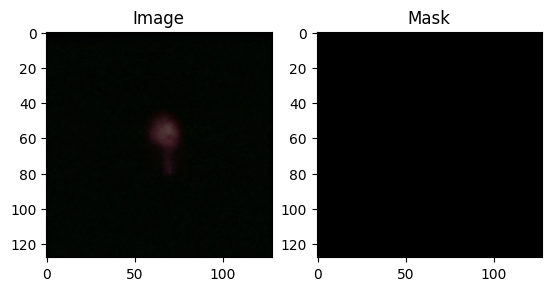

In [30]:
plt.subplot(1,2,1)
plt.imshow(X[0])
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(Y[0].squeeze(), cmap="gray")
plt.title("Mask")
plt.show()

# **split data**

In [31]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape, Y_train.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Test:", X_test.shape, Y_test.shape)

Train: (2750, 128, 128, 3) (2750, 128, 128, 1)
Validation: (589, 128, 128, 3) (589, 128, 128, 1)
Test: (590, 128, 128, 3) (590, 128, 128, 1)


# **unet_model**

In [32]:
def unet_model(input_size=(128,128,3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [33]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint("unet_model.h5", save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, verbose=1)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=6,
    batch_size=16,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/6
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9576 - loss: 0.1198

E0000 00:00:1759338294.996152     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759338295.232553     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9578 - loss: 0.1194

E0000 00:00:1759338314.517954     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759338314.754180     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 0.02752, saving model to unet_model.h5
172/172 ━━━━━━━━━━━━━━━━━━━━ 69s 263ms/step - accuracy: 0.9579 - loss: 0.1190 - val_accuracy: 0.9906 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 2/6
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9912 - loss: 0.0286
Epoch 2: val_loss did not improve from 0.02752
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9912 - loss: 0.0286 - val_accuracy: 0.9901 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 3/6
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9911 - loss: 0.0266
Epoch 3: val_loss did not improve from 0.02752
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9911 - loss: 0.0266 - val_accuracy: 0.9904 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 4/6
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9918 - loss: 0.0241
Epoch 4: val_loss did not improve from 0.02752
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9918 - loss: 0.0241 - val_acc

# **evalute**

In [35]:
loss, acc = model.evaluate(X_test, Y_test)
print("Test Accuracy:", acc)

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9911 - loss: 0.0264

E0000 00:00:1759338439.722233     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759338439.959556     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - accuracy: 0.9910 - loss: 0.0266
Test Accuracy: 0.9902378916740417


E0000 00:00:1759338448.427589     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759338448.661784     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


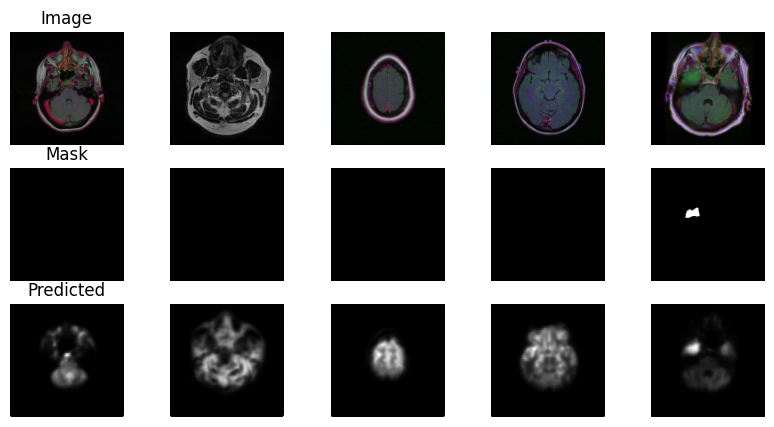

In [36]:
preds = model.predict(X_test[:5])
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[i])
    plt.axis("off")
    if i == 0: plt.title("Image")

    plt.subplot(3,5,i+6)
    plt.imshow(Y_test[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("Mask")

    plt.subplot(3,5,i+11)
    plt.imshow(preds[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0: plt.title("Predicted")
plt.show()